In [1]:
# General scientific libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.colors as mcolors
from matplotlib.colors import LogNorm, LinearSegmentedColormap, Normalize, SymLogNorm
from matplotlib import cm as colormap

from matplotlib.ticker import LogLocator, NullFormatter
import pandas as pd
import time
from string import ascii_lowercase
from scipy import signal
from scipy import special
from scipy import integrate
from scipy.special import roots_legendre, eval_legendre
from scipy.constants import mu_0, epsilon_0
# Machine Epssilon for float
import ipywidgets
import time
from PIL import Image
import os
eps = np.finfo(float).eps

In [2]:
# Specific Geophysics libraries
import empymod
#from emip1d import DeepSeaTEMIP1D as empymodipinv
# SimPEG, discretize/
import discretize
from discretize import utils
from SimPEG.electromagnetics import time_domain as tdem
from SimPEG.electromagnetics import resistivity as dc
from SimPEG.utils import mkvc, plot_1d_layer_model
from SimPEG import (
    maps,
    data,
    data_misfit,
    inverse_problem,
    regularization,
    optimization,
    directives,
    inversion,
    utils,
)
from geoana.em.tdem import diffusion_distance
from geoana.em.tdem import peak_time
from pymatsolver import Pardiso

C:\Users\81805\AppData\Local\Temp\ipykernel_29052\1447137848.py:7: FutureWarning: Importing `SimPEG` is deprecated. please import from `simpeg`.
  from SimPEG.electromagnetics import time_domain as tdem


In [3]:
from masa_utils import TEM_Signal_Process
from masa_utils import TikonovInversion
from masa_utils import PsuedoLog

Simulatin and deep sea hydrothermal deposits explortaion using WISTEM (K. Nakayama and A. Saito, 2016) (K.Nakayama M. Motoori and A. Saito,2019).
This simulates the impact of pressure vessel in 2D cyrindrical simpegEMIP(S. Kang et al, 2015). SimPEG(R. Cockett et al, 2015), simpegEM(L. Heagy et al,2017). 
On-Time: 200msec
ramp time: 200usec
Transmitter Loop: 3.5m Square Loop
Receiver Loop: Coincident-type
Number of Turn: 5
3.5m rectangular loop has equivalent area for 2.0m circular. 
Pressure vessel 
Conductivity for metal: 1e6
Conductivity for air: 1e-8
height: 0.20
Width: 0.20
Thickness: 0.04

In [4]:
base_freq=1.25
on_time=0.2
rmp_time=200e-6
rec_time=0.2
smp_freq=50e3
time_step=1./smp_freq

In [5]:
tx_side = 3.5
tx_radius = (tx_side)/(np.sqrt(np.pi))
tx_circumerence = 2*np.pi*tx_radius
tx_area = np.pi*tx_radius**2
n_turns = 5
print(f"radius of transmitter: {tx_radius}")

radius of transmitter: 1.9746635424171473


In [6]:
sigma_air = 1e-8
sigma_sea = 3.0
sigma_seabed = 1.0
sigma_vessel = 1e6
thick_target = 30.
sigma_target = 1/0.15
frame_z = 0.2
height_vessel = 0.20
width_vessel = 0.20
thick_vessel = 0.04
tx_current = 1

In [7]:
csx1, csz1 = tx_radius/200., tx_radius/200.
ncsx1, ncsz1 = 50, 50 
padx1max, padz1max = 1.3, 1.3
csx2, csz2 = tx_radius/4.,tx_radius/4.
x2max, z2max =  50., 50
x2lim, z2lim = 2000, 2000
padx2max, padz2max = 1.3, 1.3

In [8]:
csx1, csz1 = tx_radius/200., tx_radius/200.
ncsx1, ncsz1 = 50, 50 

# csx1, csz1 = tx_radius/20., tx_radius/20.
# ncsx1, ncsz1 = 5, 5 
padx1max, padz1max = 1.3, 1.3
csx2, csz2 = tx_radius/4.,tx_radius/4.
x2max, z2max =  50., 50
x2lim, z2lim = 2000, 2000
padx2max, padz2max = 1.3, 1.3

In [9]:
from masa_utils import mesh_Pressure_Vessel
hx = mesh_Pressure_Vessel(tx_radius, csx1, ncsx1, padx1max, csx2, x2max, x2lim, padx2max)
hzneg = mesh_Pressure_Vessel(tx_radius, csz1, 1, padz1max, csz2, z2max, z2lim, padz2max)
hzpos = mesh_Pressure_Vessel(tx_radius, csz1, ncsz1, padz1max, csz2, z2max, z2lim, padz2max)
hz = np.r_[hzneg[::-1], hzpos]
mesh = discretize.CylindricalMesh([hx,1,hz], x0='00C')

In [10]:
np.save("16_hx.npy", hx)
np.save("16_hz.npy", hz)

In [11]:
tx_height = tx_radius/4.
print(tx_height)
radius_vessel = csx1*50.
thickness_vessel = csz1*5.
print(f"Vessel radius: {radius_vessel:.3f}, thickness: {thickness_vessel:.3f}")

0.4936658856042868
Vessel radius: 0.494, thickness: 0.049


In [12]:
def plot_vessel_outline(ax, lw=0.3):
    x_plot_out = width_vessel*np.r_[-1,1,1,-1,-1]
    y_plot_out = height_vessel*np.r_[1,1,0,0,1]  +frame_z 
    x_plot_in = (width_vessel-thick_vessel)*np.r_[-1,1,1,-1,-1]
    y_plot_in = (height_vessel-2*thick_vessel)*np.r_[1,1,0,0,1] + thick_vessel +frame_z 

    ax.plot(x_plot_out, y_plot_out, 'k-', lw=lw)
    ax.plot(x_plot_in, y_plot_in, 'k-', lw=lw)
    return ax

def plot_frame_outline(ax, lw=0.3):
    x_plot = width_frame*np.r_[-1,1,1,-1,-1]
    y_plot = height_frame*np.r_[1,1,0,0,1] 
    ax.plot(x_plot, y_plot, 'k-', lw=lw)
    return ax


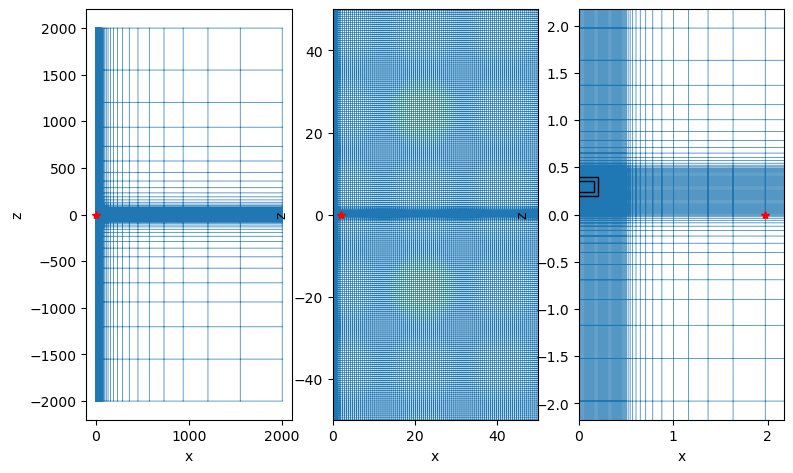

In [13]:
fig, ax = plt.subplots(1,3, figsize=(9,7))
ax[0] = mesh.plot_grid(ax=ax[0], show_it=False, linewidth=0.5)  
ax[1] =  mesh.plot_grid(ax=ax[1], show_it=False, linewidth=0.5)
ax[1].set_xlim(0.,x2max)
ax[1].set_ylim(-z2max , x2max )
ax[2] =  mesh.plot_grid(ax=ax[2], show_it=False, linewidth=0.5)
ax[2].set_xlim(0.,tx_radius*1.1)
ax[2].set_ylim(-tx_radius*1.1,tx_radius*1.1)
ax[2] = plot_vessel_outline(ax[2],lw=1.0)
for a in ax:
    a.set_aspect('equal')
    a.plot(tx_radius,0,'r*')
    a.grid(False)


## Set Up mapping

In [14]:


ind_container = (
    (mesh.cell_centers[:, 2] <= height_vessel + frame_z) &
    (mesh.cell_centers[:, 2] >= frame_z) &
    (mesh.cell_centers[:, 0] <= width_vessel)
)

ind_sea = (mesh.cell_centers[:, 2] > - tx_height) & ~ind_container
ind_active = ~ind_sea
ind_vessel = (
    (mesh.cell_centers[ind_active][:, 2] <= height_vessel + frame_z) &
    (mesh.cell_centers[ind_active][:, 2] >= frame_z) &
    (mesh.cell_centers[ind_active][:, 0] <= width_vessel)
)
ind_air = (
    (mesh.cell_centers[ind_active][:, 2] < height_vessel - thick_vessel + frame_z) &
    (mesh.cell_centers[ind_active][:, 2] > thick_vessel + frame_z) &
    (mesh.cell_centers[ind_active][:, 0] < width_vessel - thick_vessel)
)

ind_metal = ind_vessel &  ~ind_air
ind_layer = ((mesh.cell_centers[ind_active][:, 2] <= - tx_height) & 
            (mesh.cell_centers[ind_active][:, 2] > -( tx_height + thick_target)) )
ind_seabed = mesh.cell_centers[ind_active][:, 2] <= -( tx_height + thick_target)


In [15]:
print(mesh.n_cells)
print(ind_active.sum())
print(ind_vessel.sum())
print(ind_air.sum())
print(ind_metal.sum())
print(ind_layer.sum())
print(ind_seabed.sum())
assert ind_active.sum() == ind_air.sum() + ind_metal.sum() + ind_layer.sum() + ind_seabed.sum()


61664
24672
420
192
228
11844
12408


In [16]:
indices_list = [ind_metal, ind_air, ind_layer, ind_seabed]
active_map = maps.InjectActiveCells(mesh= mesh,
             indActive=ind_active  , valInactive=np.log(sigma_sea))
projection_map = maps.SurjectUnits(indices_list)
## Kill indices for the seawater

## Exponential map to convert the model to conductivity
exp_map = maps.ExpMap(mesh)
model_map = exp_map*active_map *  projection_map
#model_map = exp_map*active_map *  parametric_map

In [17]:
model_ref = np.log(np.r_[
    sigma_sea, sigma_sea, sigma_sea, sigma_sea ]
    )
model_target = np.log(np.r_[
    sigma_sea, sigma_sea, sigma_target, sigma_seabed]
    )
model_vessel = np.log(np.r_[
    sigma_vessel, sigma_air, sigma_sea, sigma_sea]
    )
model_vessel_target = np.log(np.r_[
    sigma_vessel, sigma_air, sigma_target, sigma_seabed]
    )



## time step and current
ramp time 200 $ \mu $ sec    
K. Nakayama, 2016, Practical marine TDEM systems using ROV for the ocean bottom hydrothermal deposits, Techno-Ocean Kobe, Japan, 2016


In [18]:
time_steps = [(2e-6,  150),  (5e-6,  150),  (2e-5,  150), (5e-5,  10)]
tstrt, tend = 1e-4, 4.0e-3
steps = np.array([])
for i in range(len(time_steps)):
    dt, n = time_steps[i]
    step_array = dt * np.ones(n)
    steps = np.concatenate((steps, step_array))
time_clc = np.cumsum(steps)
# since using step off waveform
rmp_time_sim = time_clc[0]
time_rec = time_clc[1:] -rmp_time_sim 


## Waveform step off


In [19]:
# rmp_time = 200e-6
# waveform = tdem.sources.RampOffWaveform(off_time = rmp_time)
waveform=tdem.sources.StepOffWaveform()
# EMF is calculated as integration of E-field over the loop wire 
rx_x = tdem.receivers.PointElectricField(
    locations=np.r_[tx_radius, 0, 0 ], times=time_rec+time_clc[0] # time_rec
    , orientation="y"
)
src = tdem.sources.CircularLoop(
    location=np.r_[0, 0, 0], radius=tx_radius, receiver_list=[rx_x],
    waveform=waveform, n_turns=n_turns,
)
survey = tdem.Survey([src])
sim = tdem.simulation.Simulation3DElectricField(
    mesh=mesh, survey=survey,  solver=Pardiso, time_steps=time_steps,
    sigmaMap=model_map
)


[2.e-06 4.e-06 6.e-06]


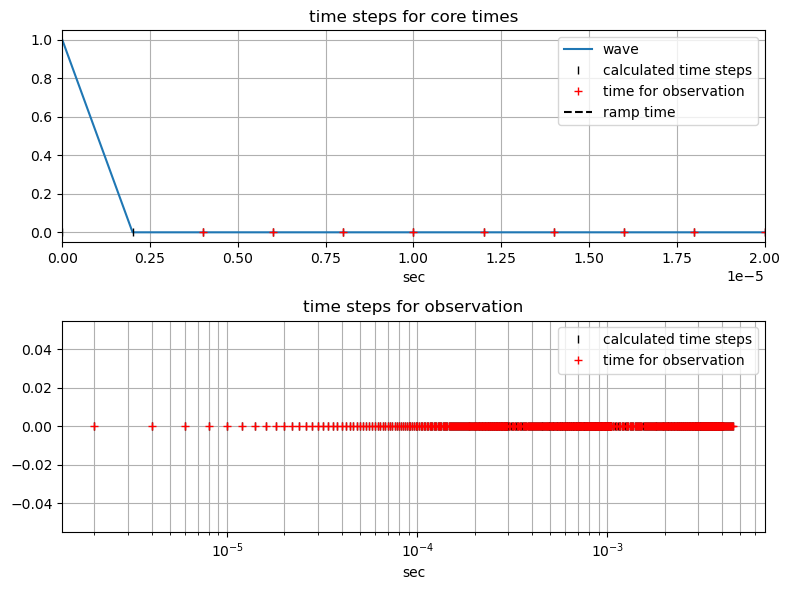

In [20]:
fig, ax = plt.subplots(2,1,figsize=(8,6))
ax[0].plot(sim.times, [waveform.eval(t) for t in sim.times],label='wave')
ax[0].plot(sim.times, np.zeros_like(sim.times), "|k",label='calculated time steps')
ax[0].plot(time_rec+time_clc[0], np.zeros_like(time_rec), "+r",lw=3,label='time for observation')
ax[0].axvline(rmp_time, color='k', linestyle='--',label='ramp time')
ax[0].set_xlim(0,20e-6)#time_steps[0][0]*time_steps[0][1])
ax[0].set_title('time steps for core times')

ax[1].semilogx(sim.times, np.zeros_like(sim.times), "|k",label='calculated time steps')
ax[1].semilogx(time_rec, np.zeros_like(time_rec), "+r",lw=3,label='time for observation')
ax[1].set_title('time steps for observation')
print(time_rec[:3])
for a in ax:
    a.grid(which='both')
    a.set_xlabel('sec')
    a.legend()
plt.tight_layout()
plt.show()

## Plot model

In [21]:
def plot_model(model, clim=[-8,6], xlim=[-3,3], ylim=[-3.,3], ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1)
    
    # Plot the image and add a color bar
    img = mesh.plot_image(np.log10(model_map * model), clim=clim, ax=ax, mirror=True)[0]
    cb = plt.colorbar(img, ax=ax, shrink=0.4)  # Adjust the 'shrink' parameter to control height

    # Plot the source locations and earth surface
    ax.plot(np.r_[src.radius, -src.radius], 
            np.r_[src.location[2], src.location[2]], "ko-", markersize=3)
    
    # Format the color bar
    cb.set_label('$\log_{10}\sigma$', fontsize=13)

    # Set axis limits and aspect ratio
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_aspect('equal')
    ax.set_xlabel('x (m)')
    ax.set_ylabel('z (m)')
    ax.grid(which='both', color='k', linestyle='-', linewidth=0.2)
    ax.set_title('Conductivity Model')
    plt.tight_layout()
    
    return ax


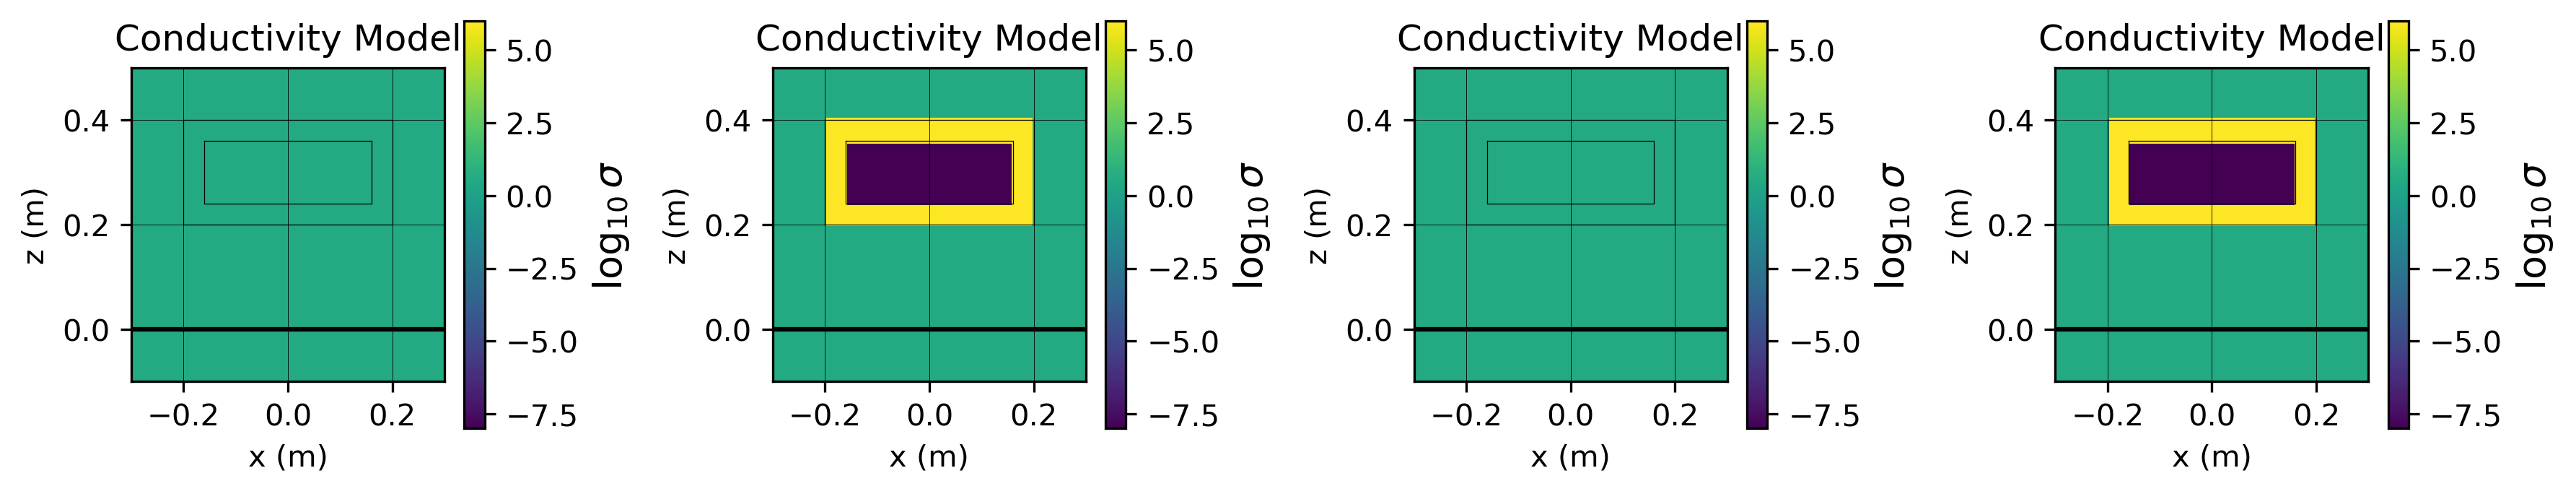

In [22]:
fig , ax = plt.subplots(1,4,figsize=(12,5), dpi=300)
ax = ax.flatten()
xlim, ylim = [-0.3, 0.3], [-0.1,0.5]
clim=[-8,6]
ax[0]=plot_model(model= model_ref, xlim=xlim,ylim=ylim,clim=clim, ax=ax[0])
ax[1]=plot_model(model= model_vessel, xlim=xlim,ylim=ylim,clim=clim, ax=ax[1])
ax[2]=plot_model(model= model_target, xlim=xlim,ylim=ylim,clim=clim,ax=ax[2])
ax[3]=plot_model(model= model_vessel_target, xlim=xlim,ylim=ylim,clim=clim, ax=ax[3])

for a in ax:
    plot_vessel_outline(ax=a)
plt.tight_layout()
plt.savefig('16_models_vessel.png', dpi=300)

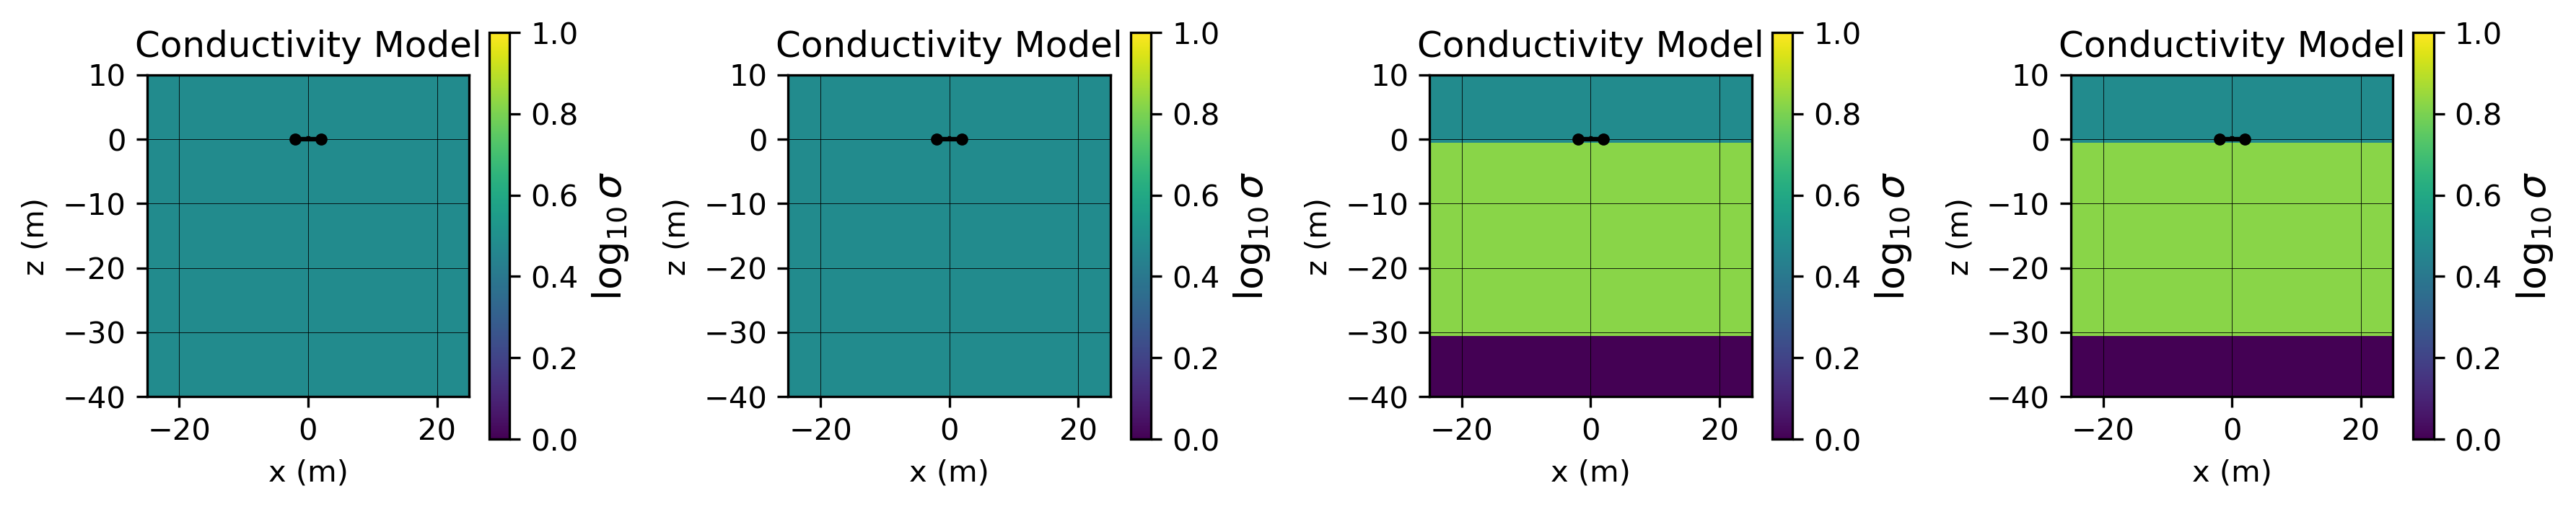

In [23]:
fig , ax = plt.subplots(1,4,figsize=(12,5), dpi=300)
ax = ax.flatten()
xlim, ylim = [-25, 25], [-40,10]
clim=[0,1]
ax[0]=plot_model(model= model_ref,    xlim=xlim,ylim=ylim,clim=clim, ax=ax[0])
ax[1]=plot_model(model= model_vessel, xlim=xlim,ylim=ylim,clim=clim, ax=ax[1])
ax[2]=plot_model(model= model_target, xlim=xlim,ylim=ylim,clim=clim, ax=ax[2])
ax[3]=plot_model(model= model_vessel_target, xlim=xlim,ylim=ylim,clim=clim, ax=ax[3])

for a in ax:
    plot_vessel_outline(ax=a)
plt.tight_layout()
plt.savefig('16_models_layer.png', dpi=300)

# Simulation

In [24]:
## Simulation
fields_ref = sim.fields(model_ref)
sim_ref =sim.dpred(model_ref, f=fields_ref)
print(f"reference model done")
dpred_ref   = tx_circumerence*sim_ref

reference model done


In [25]:

fields_vessel = sim.fields(model_vessel)
sim_vessel = sim.dpred(model_vessel, f=fields_vessel)
dpred_vessel = tx_circumerence*sim_vessel
print(f"vessel model done")

vessel model done


In [26]:
fields_target = sim.fields(model_target)
sim_target =sim.dpred(model_ref, f=fields_target)
print(f"reference model done")
dpred_target   = tx_circumerence*sim_target

reference model done


In [27]:
fields_vessel_target = sim.fields(model_vessel_target)
sim_vessel_target =sim.dpred(model_ref, f=fields_vessel_target)
print(f"reference model done")
dpred_vessel_target   = tx_circumerence*sim_vessel_target

reference model done


# Road simpegEMIP data

In [28]:
np_saved = np.load("13_Validation_simpegEMIP.npy")
times_rec_simpegEMIP = np_saved[0,:]
dpred_IP = np_saved[2,:]
np_saved = np.load("14_Pressure_vessel_LayerIP.npy")
times_rec_simpegEMIP = np_saved[0,:]
dpred_IP_vessel = np_saved[1,:]
dpred_IP = np_saved[2,:]
fields_saved = np.load("14_fields_emip.npy")

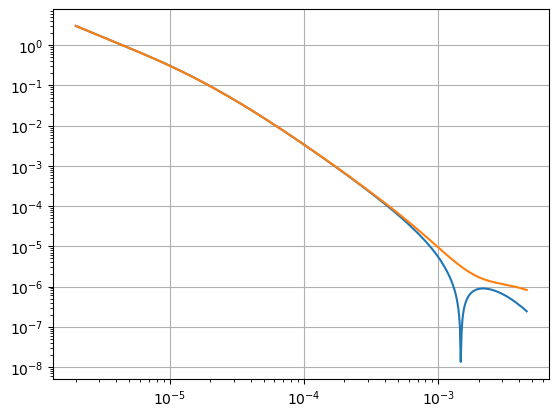

In [29]:
plt.loglog(times_rec_simpegEMIP,np.abs(dpred_IP))
plt.loglog(times_rec_simpegEMIP,np.abs(dpred_IP_vessel))
plt.grid()

# EMF directly from dBdt and E fields

In [30]:
ind_loop_dbdt = (
    (mesh.faces[:, 0] <= tx_radius +eps) 
    & (mesh.faces[:, 2] >  -( 0.1 * csz1 +eps)) 
    & (mesh.faces[:, 2] <  ( 0.1 * csz1 +eps))  
    )
print(ind_loop_dbdt.sum())   
print(mesh.faces[ind_loop_dbdt])
print(mesh.faces[ind_loop_dbdt].shape)
face_areas = mesh.face_areas[ind_loop_dbdt]
print(face_areas)
print(face_areas.sum())
dBdt = np.r_[mesh.edge_curl * fields_saved[:,:]][ind_loop_dbdt] 
print(dBdt.shape)
print(face_areas.shape)
#face_areas = mesh.face_areas[:, np.newaxis]
#dBdt = mesh.face_areas[ind_loop_dbdt] * dBdt[ind_loop_dbdt]   
dBdt_area =   dBdt.T @ face_areas
dBdt_area = n_turns*dBdt_area.squeeze()
print(dBdt_area.shape)


64
[[4.93665886e-03 0.00000000e+00 4.95624375e-12]
 [1.48099766e-02 0.00000000e+00 4.95624375e-12]
 [2.46832943e-02 0.00000000e+00 4.95624375e-12]
 [3.45566120e-02 0.00000000e+00 4.95624375e-12]
 [4.44299297e-02 0.00000000e+00 4.95624375e-12]
 [5.43032474e-02 0.00000000e+00 4.95624375e-12]
 [6.41765651e-02 0.00000000e+00 4.95624375e-12]
 [7.40498828e-02 0.00000000e+00 4.95624375e-12]
 [8.39232006e-02 0.00000000e+00 4.95624375e-12]
 [9.37965183e-02 0.00000000e+00 4.95624375e-12]
 [1.03669836e-01 0.00000000e+00 4.95624375e-12]
 [1.13543154e-01 0.00000000e+00 4.95624375e-12]
 [1.23416471e-01 0.00000000e+00 4.95624375e-12]
 [1.33289789e-01 0.00000000e+00 4.95624375e-12]
 [1.43163107e-01 0.00000000e+00 4.95624375e-12]
 [1.53036425e-01 0.00000000e+00 4.95624375e-12]
 [1.62909742e-01 0.00000000e+00 4.95624375e-12]
 [1.72783060e-01 0.00000000e+00 4.95624375e-12]
 [1.82656378e-01 0.00000000e+00 4.95624375e-12]
 [1.92529695e-01 0.00000000e+00 4.95624375e-12]
 [2.02403013e-01 0.00000000e+00 4.956

In [31]:
ind_loop_e = (
       (mesh.edges[:, 0] > - 0.1*csx1 + tx_radius)
    &  (mesh.edges[:, 0] < + 0.1*csx1 + tx_radius)
    & (mesh.edges[:, 2] >  -( 0.1 * csz1 ))
    & (mesh.edges[:, 2] <  ( 0.1 * csz1 ))
)
print(ind_loop_e.sum())
print(mesh.edges[ind_loop_e])
edge_length = mesh.edge_lengths[ind_loop_e]
print(edge_length)
e_edge_length = np.r_[edge_length * fields_saved[ind_loop_e]][0,:] 
EMF_fields = n_turns * e_edge_length
print(e_edge_length.shape)

1
[[1.97466354e+00 0.00000000e+00 4.95624375e-12]]
[12.40717696]
(459,)


(64, 459)


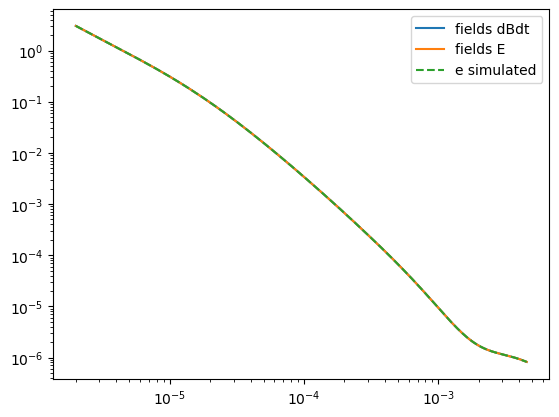

In [32]:

#dBdt = np.sum(dBdt,axis=0).T
print(dBdt.shape)
#plt.semilogx(time_emip,n_turns*dBdt.T, label="fields") 
plt.loglog(times_rec_simpegEMIP    ,np.abs(dBdt_area), label="fields dBdt ") 
plt.loglog(times_rec_simpegEMIP,np.abs(EMF_fields), label="fields E")
plt.loglog(times_rec_simpegEMIP,np.abs(dpred_IP_vessel),"--" ,label="e simulated")

plt.legend()

# apply linearly cut off ramp

In [33]:
WISTEM_SP_sim = TEM_Signal_Process (
    base_freq=base_freq,
    on_time=on_time, 
    rmp_time=rmp_time, 
    rec_time=tend, 
    smp_freq=smp_freq*4
)  
times_rec = WISTEM_SP_sim.times_rec
times_filt = WISTEM_SP_sim.times_filt
filt_linrmp = WISTEM_SP_sim.filter_linear_rmp()

In [34]:
dpred_ref_interp = WISTEM_SP_sim.interpolate_data(
    data=dpred_ref, times= time_rec
 )
dpred_ref_LPF = WISTEM_SP_sim.apply_lowpass_filter(
    data=dpred_ref_interp, cutoff=smp_freq/2.0
)
dpred_ref_linrmp = signal.convolve(
    dpred_ref_LPF,filt_linrmp)[:len(dpred_ref_interp)]

In [35]:
dpred_interp = WISTEM_SP_sim.interpolate_data(
    data=dpred_vessel, times= time_rec
 )
dpred_vessel_LPF = WISTEM_SP_sim.apply_lowpass_filter(
    data=dpred_interp, cutoff=smp_freq/2.0
)
dpred_vessel_linrmp = signal.convolve(
    dpred_vessel_LPF,filt_linrmp)[:len(dpred_vessel_LPF)]

In [36]:
dpred_interp = WISTEM_SP_sim.interpolate_data(
    data=dpred_target, times= time_rec
 )
dpred_target_LPF = WISTEM_SP_sim.apply_lowpass_filter(
    data=dpred_interp, cutoff=smp_freq/2.0
)
dpred_target_linrmp = signal.convolve(
    dpred_target_LPF,filt_linrmp)[:len(dpred_target_LPF)]

In [37]:
dpred_interp = WISTEM_SP_sim.interpolate_data(
    data=dpred_vessel_target,times= time_rec
 )
dpred_vessel_target_LPF = WISTEM_SP_sim.apply_lowpass_filter(
    data=dpred_interp, cutoff=smp_freq/2.0
)
dpred_vessel_target_linrmp = signal.convolve(
    dpred_vessel_target_LPF,filt_linrmp)[:len(dpred_vessel_target_LPF)]

In [38]:
dpred_interp = WISTEM_SP_sim.interpolate_data(
    data=dpred_IP,times= times_rec_simpegEMIP
 )
dpred_IP_LPF = WISTEM_SP_sim.apply_lowpass_filter(
    data=dpred_interp, cutoff=smp_freq/2.0
)
dpred_IP_linrmp = signal.convolve(
    dpred_IP_LPF,filt_linrmp)[:len(dpred_IP_LPF)]

In [39]:
dpred_interp = WISTEM_SP_sim.interpolate_data(
    data=dpred_IP_vessel,times= times_rec_simpegEMIP
 )
dpred_IP_vessel_LPF = WISTEM_SP_sim.apply_lowpass_filter(
    data=dpred_interp, cutoff=smp_freq/2.0
)
dpred_IP_vessel_linrmp = signal.convolve(
    dpred_IP_vessel_LPF,filt_linrmp)[:len(dpred_IP_vessel_LPF)]

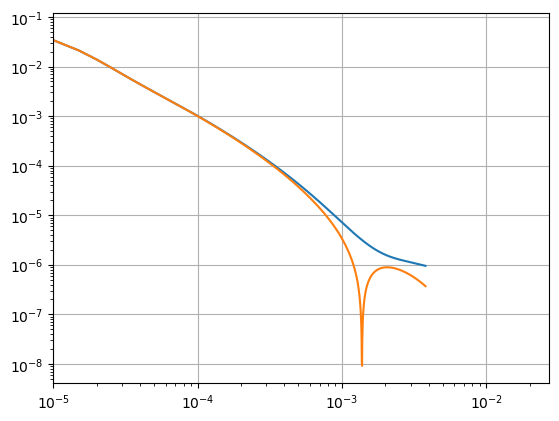

In [40]:
plt.loglog(times_rec-rmp_time,np.abs(dpred_IP_vessel_linrmp))
plt.loglog(times_rec-rmp_time,np.abs(dpred_IP_linrmp))
plt.xlim(left=1e-5)
plt.grid()

# Plot

In [41]:
PL_decay = PsuedoLog(
    logmin=1e-7,
    linScale=0.2,
    logminx=1e-4,
    linScalex=0.2
    )
PL_filt = PsuedoLog(
    logmin=1e-7,
    linScale=0.2,
    logminx=1e-4,
    linScalex=0.2
    )

# Ratio

Text(0.5, 1.0, 'Ratio test for conductive model')

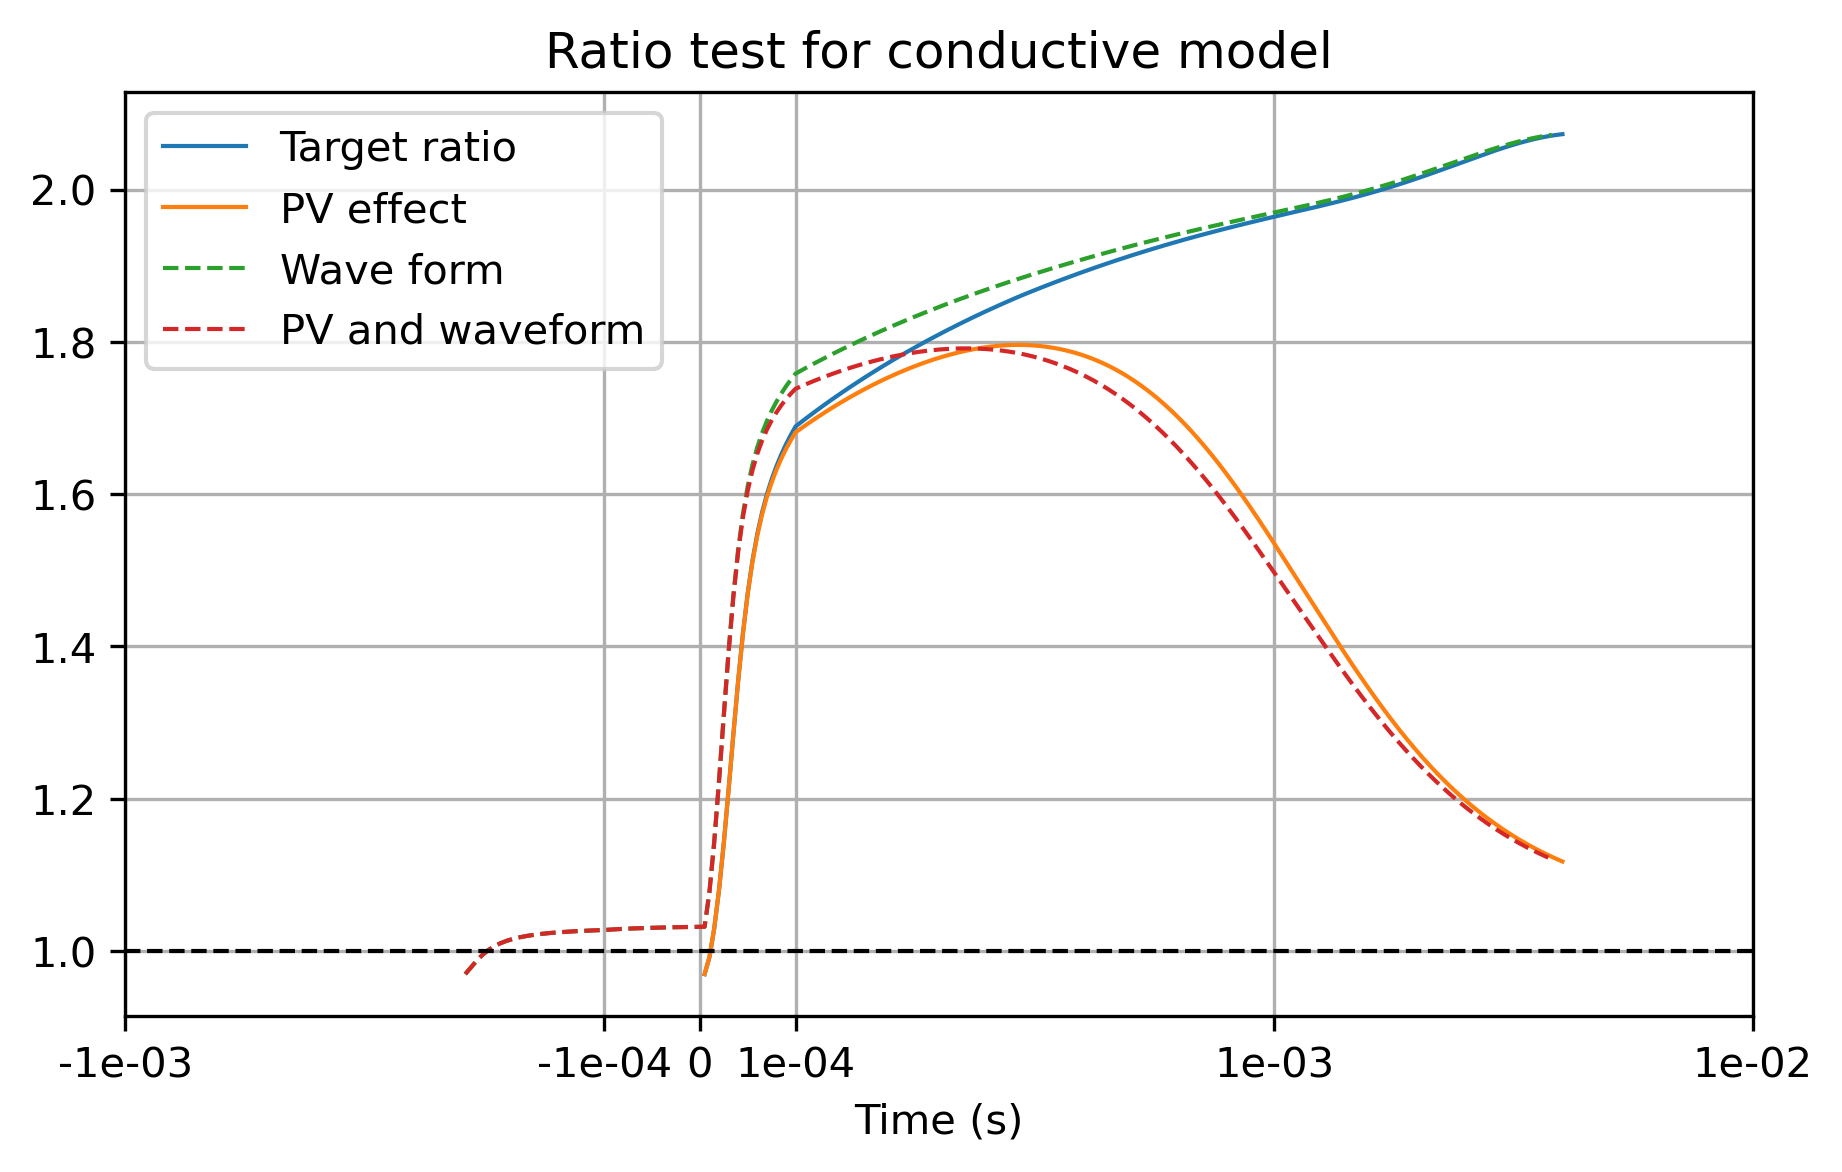

In [42]:
# Conductive model
fig, ax = plt.subplots(1, 1, figsize=(7,4),dpi=300)
#    ax.loglog(times_sim, dobs_ref, "k-", label="data of reference model")
off_time = 0
ax=PL_decay.semiplx(x=times_rec-off_time,y=dpred_target_LPF/dpred_ref_LPF,
   yscale_log=False, color="C0",label="Target ratio",ax=ax)
ax=PL_decay.semiplx(x=times_rec-off_time,y=dpred_vessel_target_LPF/ dpred_vessel_LPF,
   yscale_log=False, color="C1",label="PV effect",ax=ax)
off_time = rmp_time
ax=PL_decay.semiplx(x=times_rec-off_time,y=dpred_target_linrmp/dpred_ref_linrmp,
   yscale_log=False, linestyle="--",color="C2",label="Wave form",ax=ax)
ax=PL_decay.semiplx(x=times_rec-off_time,y=dpred_vessel_target_linrmp/ dpred_vessel_linrmp,
   yscale_log=False, linestyle="--", color="C3",label="PV and waveform",ax=ax)
plt.axhline( y=1.0, color="k", linewidth=1.0,linestyle="--")
PL_decay.pl_axes_x(ax=ax)
ax.legend()
ax.grid(True)
ax.set_xlabel("Time (s)")
ax.set_title("Ratio test for conductive model")

Text(0.5, 1.0, 'Ratio test for IP model')

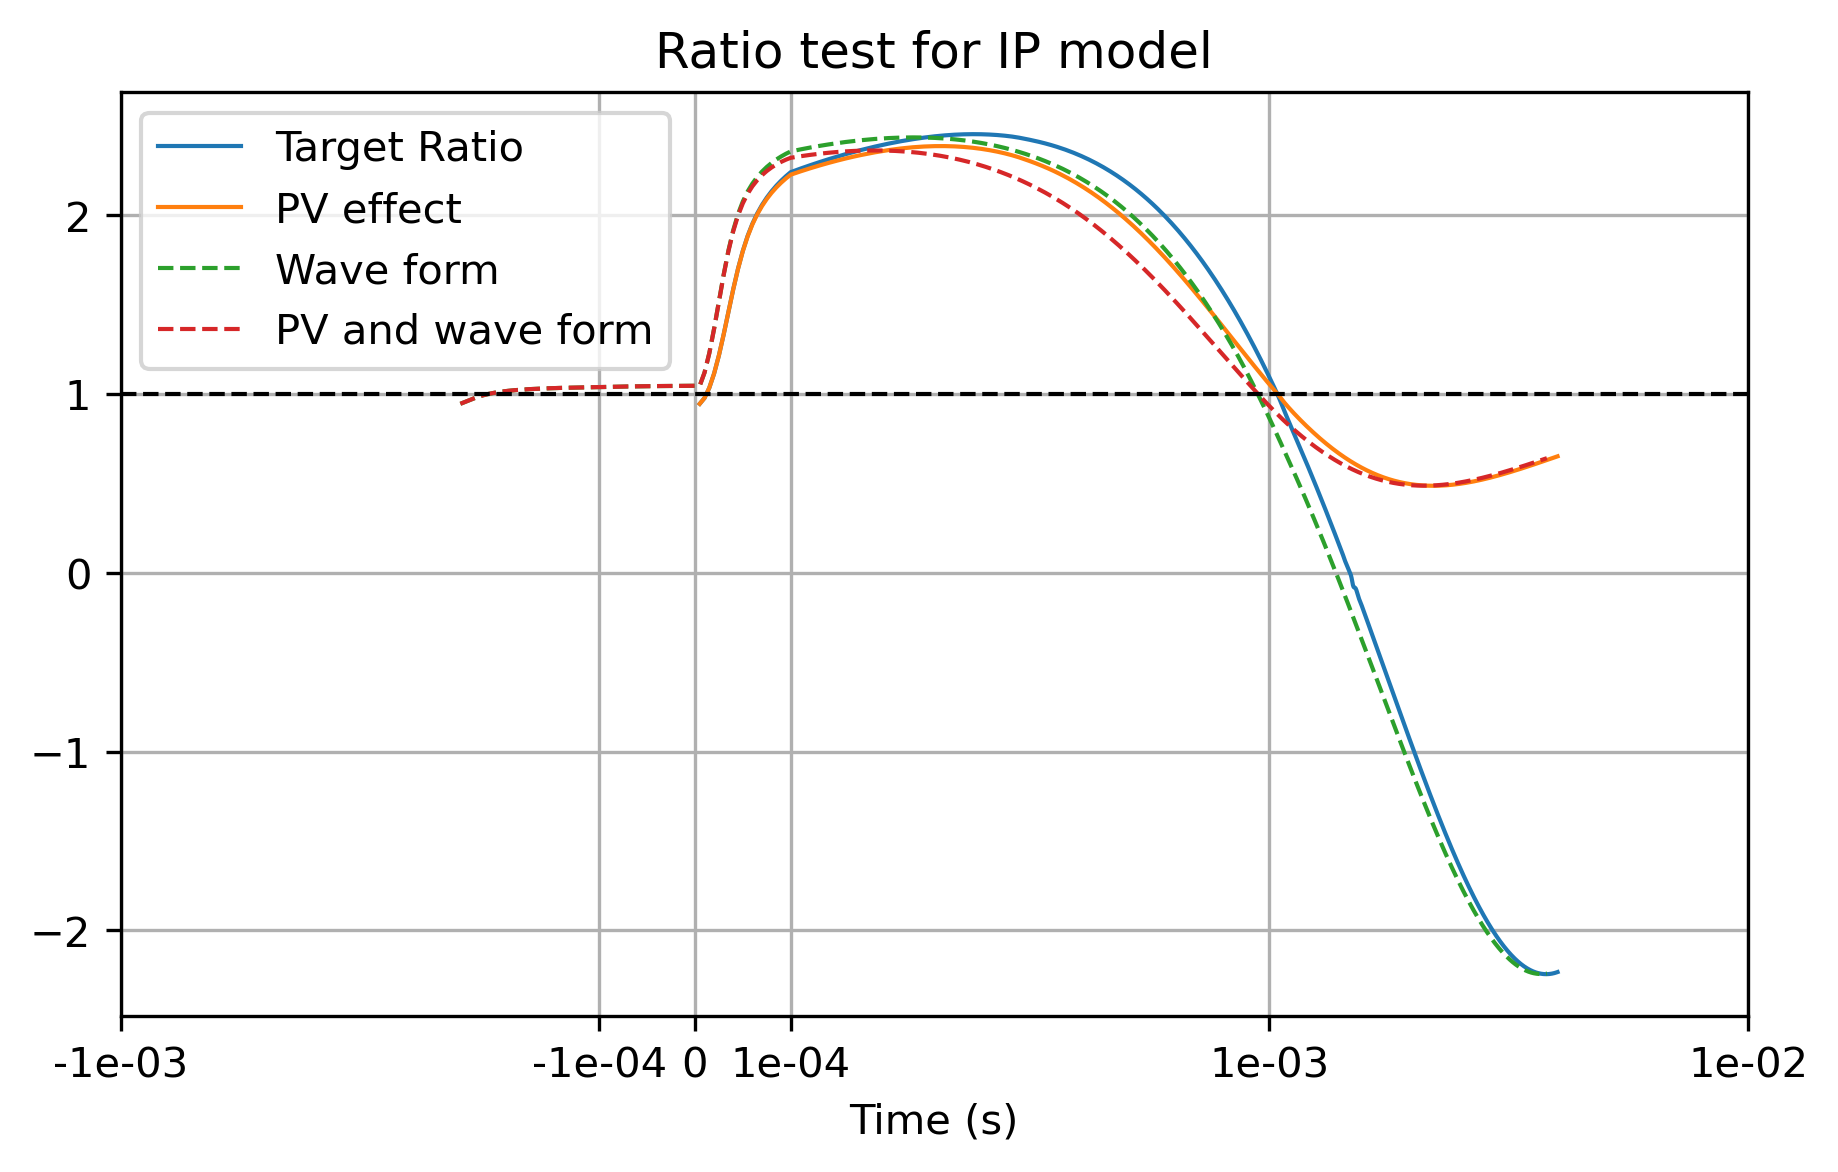

In [43]:
fig, ax = plt.subplots(1, 1, figsize=(7,4),dpi=300)
#    ax.loglog(times_sim, dobs_ref, "k-", label="data of reference model")
off_time = 0
ax=PL_decay.semiplx(x=times_rec-off_time,y=dpred_IP_LPF/dpred_ref_LPF,
   yscale_log=False, color="C0",label="Target Ratio",ax=ax)
ax=PL_decay.semiplx(x=times_rec-off_time,y=dpred_IP_vessel_LPF/ dpred_vessel_LPF,
   yscale_log=False, color="C1",label="PV effect",ax=ax)
off_time = rmp_time
ax=PL_decay.semiplx(x=times_rec-off_time,y=dpred_IP_linrmp/dpred_ref_linrmp,
   yscale_log=False, linestyle="--",color="C2",label="Wave form",ax=ax)
ax=PL_decay.semiplx(x=times_rec-off_time,y=dpred_IP_vessel_linrmp/ dpred_vessel_linrmp,
   yscale_log=False, linestyle="--",color="C3",label="PV and wave form",ax=ax)
plt.axhline( y=1.0, color="k", linewidth=1.0,linestyle="--")
PL_decay.pl_axes_x(ax=ax)
ax.legend()
ax.grid(True)
ax.set_xlabel("Time (s)")
ax.set_title("Ratio test for IP model")

## Deconvolution test

In [44]:
filt_decnv = WISTEM_SP_sim.deconvolve(
    data=dpred_ref_linrmp, data_pulse=dpred_ref_LPF)

[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  2.67597170e-30
  5.57251752e-30 -1.70693729e-30]
5.899164589904475e-07


In [45]:
filt_decnv_sys = WISTEM_SP_sim.deconvolve(
    data=dpred_vessel_linrmp, data_pulse=dpred_ref_LPF)

[ 0.00000000e+00  0.00000000e+00 -6.93889390e-18 ... -2.85006178e-13
 -1.89544474e-13 -9.45431149e-14]
1.3886763935456696e-06


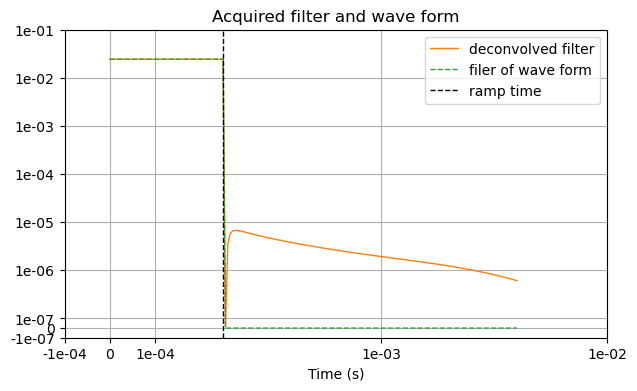

In [46]:
fig, ax = plt.subplots(1, 1, figsize=(7,4))
#    ax.loglog(times_sim, dobs_ref, "k-", label="data of reference model")
ax =PL_filt.plpl_plot(x= times_filt, y=filt_decnv_sys,
    linestyle="-", color="C1",label="deconvolved filter",ax=ax)
ax =PL_filt.plpl_plot(x= times_filt, y=filt_linrmp ,
    linestyle="--", color="C2",label="filer of wave form",ax=ax)
PL_decay.pl_axvline(x=rmp_time, ax=ax, color="k",label="ramp time")
PL_filt.pl_axes(ax=ax)
PL_filt.pl_axes_x(ax=ax)

ax.legend()
ax.grid(True)
ax.set_xlabel("Time (s)")
ax.set_title("Acquired filter and wave form")
plt.savefig('16_Filter.png', dpi=300)

# Convolve filter to target

In [47]:
dpred_target_filt = signal.convolve(
    dpred_target_LPF, filt_decnv_sys
    )[:len(dpred_target_LPF)]
dpred_IP_filt = signal.convolve(
    dpred_IP_LPF, filt_decnv_sys
    )[:len(dpred_target_LPF)]

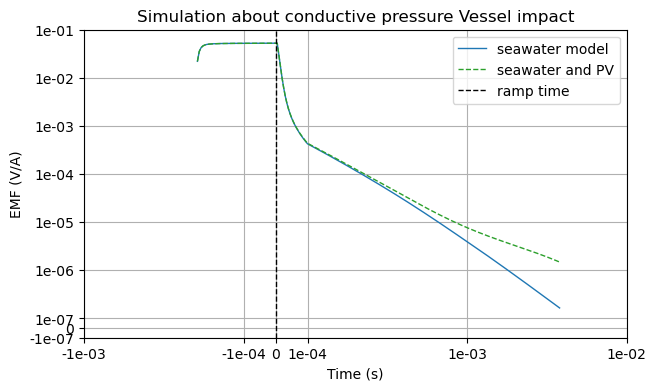

In [48]:
fig, ax = plt.subplots(1,1, figsize=(7,4))
PL_decay.plpl_plot(x=times_rec-rmp_time, y=dpred_ref_linrmp, ax=ax
    , label='seawater model', linestyle='-', color='C0')
PL_decay.plpl_plot(x=times_rec-rmp_time, y=dpred_vessel_linrmp, ax=ax
    , label='seawater and PV', linestyle='--', color='C2')
PL_decay.pl_axvline(x=0, ax=ax, color="k",label="ramp time")
PL_decay.pl_axes(ax=ax)
PL_decay.pl_axes_x(ax=ax)
ax.grid(True)
ax.legend()
ax.legend()
ax.set_ylabel('EMF (V/A)')
ax.set_xlabel('Time (s)')
ax.set_title("Simulation about conductive pressure Vessel impact")
plt.savefig('16_Sim_ref.png', dpi=300)

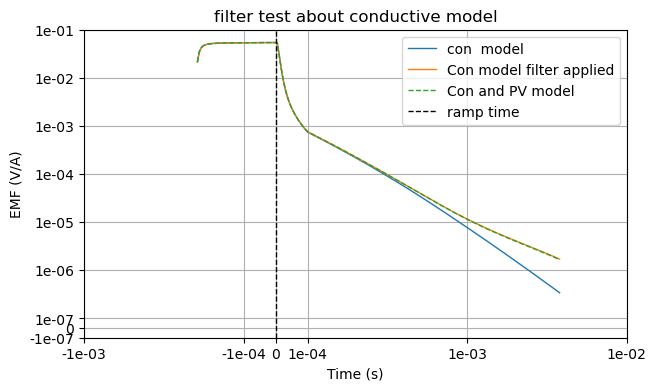

In [49]:
fig, ax = plt.subplots(1,1, figsize=(7,4))
PL_decay.plpl_plot(x=times_rec-rmp_time, y=dpred_target_linrmp, ax=ax
    , label='con  model', linestyle='-', color='C0')
PL_decay.plpl_plot(x=times_rec-rmp_time, y=dpred_target_filt, ax=ax
    , label='Con model filter applied', linestyle='-', color='C1')
PL_decay.plpl_plot(x=times_rec-rmp_time, y=dpred_vessel_target_linrmp, ax=ax
    , label='Con and PV model', linestyle='--', color='C2')
PL_decay.pl_axvline(x=0, ax=ax, color="k",label="ramp time")
PL_decay.pl_axes(ax=ax)
PL_decay.pl_axes_x(ax=ax)
ax.grid(True)
ax.legend()
ax.set_ylabel('EMF (V/A)')
ax.set_xlabel('Time (s)')
ax.set_title("filter test about conductive model")
plt.savefig('16_Sim_con.png', dpi=300)

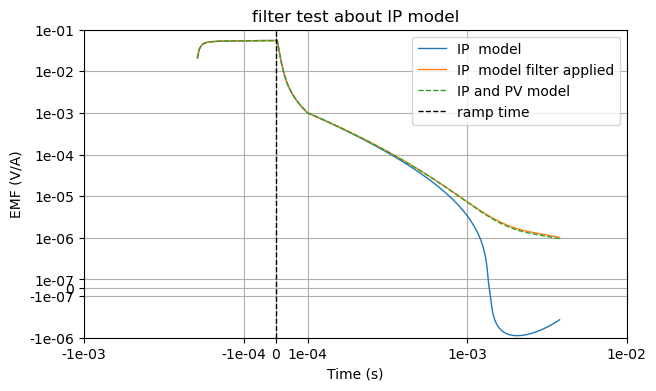

In [50]:
fig, ax = plt.subplots(1,1, figsize=(7,4))
PL_decay.plpl_plot(x=times_rec-rmp_time, y=dpred_IP_linrmp, ax=ax
    , label='IP  model', linestyle='-', color='C0')
PL_decay.plpl_plot(x=times_rec-rmp_time, y=dpred_IP_filt, ax=ax
    , label='IP  model filter applied', linestyle='-', color='C1')
PL_decay.plpl_plot(x=times_rec-rmp_time, y=dpred_IP_vessel_linrmp, ax=ax
    , label='IP and PV model', linestyle='--', color='C2')

PL_decay.pl_axvline(x=0, ax=ax, color="k",label="ramp time")
PL_decay.pl_axes(ax=ax)
PL_decay.pl_axes_x(ax=ax)
ax.grid(True)
ax.legend()
ax.set_ylabel('EMF (V/A)')
ax.set_xlabel('Time (s)')
ax.set_title("filter test about IP model")
plt.savefig('16_Sim_IP.png', dpi=300)